# Local Model-Agnostic Methods

Local models focus on interpreting individual predictions and how changes affect the outcome of that specific prediction. Model-agnostic means that the methods can be applied to any model type, typically focusing on post-model creation explanation

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 05/05/2025   | Martin | Created   | Notebook created for section 2. Started on Ceteris Paribus Plots | 
| 06/05/2025   | Martin | Created   | Completed Ceteris Paribus Plots. Started ICE | 
| 12/05/2025   | Martin | Created   | Completed ICE plots | 
| 13/05/2025   | Martin | Created   | Started LIME method | 

# Content

* [Ceteris Paribus Plots](#ceteris-paribus-plots)
* [Individual Conditional Expectation (ICE)](#individual-conditional-expectation-ice)
* [LIME](#lime)

# Ceteris Paribus Plots

Looks at one feature at a time, systematically changes its values, and plots how the prediction changes across the range of the feature.

Method for categorical and numerical data is different

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ceteris_paribus.explainer import explain
from ceteris_paribus.profiles import individual_variable_profile
from ceteris_paribus.plots.plots import plot

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR

In [2]:
df = pl.read_csv('./data/penguins/penguins_cleaned.csv')
df.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,f64,f64,str
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""
"""Adelie""","""Torgersen""",40.3,18.0,195.0,3250.0,"""FEMALE"""
"""Adelie""","""Torgersen""",36.7,19.3,193.0,3450.0,"""FEMALE"""
"""Adelie""","""Torgersen""",39.3,20.6,190.0,3650.0,"""MALE"""


In [7]:
# Convert categorical variables to numerical
df = df.with_columns(
  pl.col(['species', 'island', 'sex']).map_batches(LabelEncoder().fit_transform)
)

# Remove the last entry as the test point
train = df[:-1]
test = df[-1]

# Split training and test data
y_train = train['sex']
X_train = train.drop('sex')
y_test = test['sex']
X_test = test.drop('sex')

# Train a RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
NUM_TESTS = 200
variable = 'culmen_depth_mm'

# Generating range of variable
gen_culmen = np.linspace(X_train[variable].min(), X_train[variable].max(), NUM_TESTS)

# Create the new test dataset for plot
X_test_cp = X_test.clone()
X_test_cp = X_test_cp.select(pl.all().repeat_by(NUM_TESTS).flatten())

# Replacevariable values
X_test_cp = X_test_cp.with_columns(
  pl.Series(variable, gen_culmen)
)
X_test_cp = pl.concat([X_test_cp, X_test], how='vertical')
X_test_cp.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
i64,i64,f64,f64,f64,f64
2,0,49.9,13.1,213.0,5400.0
2,0,49.9,13.142211,213.0,5400.0
2,0,49.9,13.184422,213.0,5400.0
2,0,49.9,13.226633,213.0,5400.0
2,0,49.9,13.268844,213.0,5400.0


In [19]:
# Create dataframe for plotting
p_female = rfc.predict_proba(X_test_cp)[:, 1]
df_plot = pd.DataFrame(
  {
    variable: X_test_cp[variable],
    'P(female)': p_female
  }
)

# Separate the actual point
actual = df_plot.iloc[-1, :]
df_plot = df_plot.iloc[:-1, :]

In [20]:
df_plot

,culmen_depth_mm,P(female)
0,13.100000,0.77
1,13.142211,0.77
2,13.184422,0.77
3,13.226633,0.77
4,13.268844,0.77
...,...,...
195,21.331156,0.99
196,21.373367,0.99
197,21.415578,0.99
198,21.457789,0.99


Text(0, 0.5, 'P(female)')

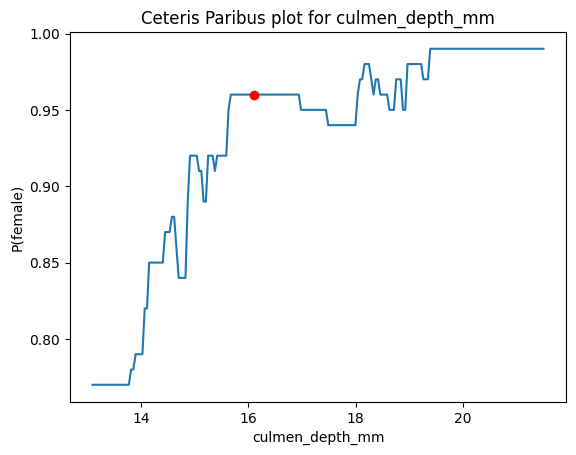

In [21]:
plt.plot(variable, 'P(female)', data=df_plot)
plt.scatter(variable, 'P(female)', data=actual, color='r', zorder=10)
plt.title(f'Ceteris Paribus plot for {variable}')
plt.xlabel(variable)
plt.ylabel('P(female)')

Observe the impact of all features

In [48]:
df = pl.read_csv('./data/bike_rental/day_cleaned.csv')

# Select columns
cols = [
  'holiday',
  'season',
  'weather_rmp',
  'workingday',
  'cnt_2d_bfr',
  'rel_hum',
  'temp_cel',
  'windspeed_kmh',
  'cnt'
]
df = df[cols]

df.head()

holiday,season,weather_rmp,workingday,cnt_2d_bfr,rel_hum,temp_cel,windspeed_kmh,cnt
i64,i64,i64,i64,i64,f64,f64,f64,i64
0,1,1,1,985,43.7273,8.050924,16.636703,1349
0,1,1,1,801,59.0435,8.2,10.739832,1562
0,1,1,1,1349,43.6957,9.305237,12.5223,1600
0,1,1,1,1562,51.8261,8.378268,6.0008684,1606
0,1,2,1,1600,49.8696,8.057402,11.304642,1510


In [49]:
# Split and train
y = df['cnt']
X = df.drop('cnt')

svr = SVR()
svr.fit(X, y)

SVR()

In [ ]:
# Creating the explainer and cp plots for all features
explainer = explain(svr, X.columns, X, y)

cp_profile = individual_variable_profile(explainer, X[1:5], y=y[1:5], variables=X.columns)
plot(cp_profile)

---

# Individual Conditional Expectation (ICE)

Using PiML an all-in-one toolkit for different explainable ML APIs, but is a bit more restrictive

In [2]:
from piml import Experiment
from piml.models import XGB2Regressor

In [3]:
# Define the experiment and load data
exp = Experiment()
exp.data_loader(data='BikeSharing', silent=True)
exp.data_summary(feature_exclude=['yr', 'mnth', 'temp'])

Numerical Attributes 
 
 
   
 name 
 n_missing 
 mean 
 std 
 min 
 q1 
 median 
 q3 
 max 
 
 
 
 
 0 
 mnth 
 0 
 6.5378 
 3.4388 
 1.0000 
 4.0000 
 7.0000 
 10.0000 
 12.0000 
 
 
 1 
 hr 
 0 
 11.5468 
 6.9144 
 0.0000 
 6.0000 
 12.0000 
 18.0000 
 23.0000 
 
 
 2 
 weekday 
 0 
 3.0037 
 2.0058 
 0.0000 
 1.0000 
 3.0000 
 5.0000 
 6.0000 
 
 
 3 
 temp 
 0 
 0.4970 
 0.1926 
 0.0200 
 0.3400 
 0.5000 
 0.6600 
 1.0000 
 
 
 4 
 atemp 
 0 
 0.4758 
 0.1719 
 0.0000 
 0.3333 
 0.4848 
 0.6212 
 1.0000 
 
 
 5 
 hum 
 0 
 0.6272 
 0.1929 
 0.0000 
 0.4800 
 0.6300 
 0.7800 
 1.0000 
 
 
 6 
 windspeed 
 0 
 0.1901 
 0.1223 
 0.0000 
 0.1045 
 0.1940 
 0.2537 
 0.8507 
 
 
 7 
 cnt 
 0 
 189.4631 
 181.3876 
 1.0000 
 40.0000 
 142.0000 
 281.0000 
 977.0000 
 
 
 

 
 Categorical Attributes 
 
 
   
 name 
 n_missing 
 n_unique 
 top1 
 top2 
 top3 
 n_others 
 
 
 
 
 0 
 season 
 0 
 4 
 3.0 : 4496 
 2.0 : 4409 
 1.0 : 4242 
 4232 
 
 
 1 
 yr 
 0 
 2 
 1.0 : 8734 
 0.0 : 8645 
 0 
 0 
 
 
 2 
 holiday 
 0 
 2 
 0.0 : 16879 
 1.0 : 500 
 0 
 0 
 
 
 3 
 workingday 
 0 
 2 
 1.0 : 11865 
 0.0 : 5514 
 0 
 0 
 
 
 4 
 weathersit 
 0 
 4 
 1.0 : 11413 
 2.0 : 4544 
 3.0 : 1419 
 3

Data Shape:(17379, 13)


In [4]:
exp.data_prepare(target='cnt', task_type='regression')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Config,Value
0,Excluded columns,"[temp, mnth, yr]"
1,Target variable,cnt
2,Sample weight,None
3,Task type,regression
4,Split method,random
5,Test ratio,0.2
6,Random state,0


In [5]:
exp.model_train(model=XGB2Regressor(), name='XGB2')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

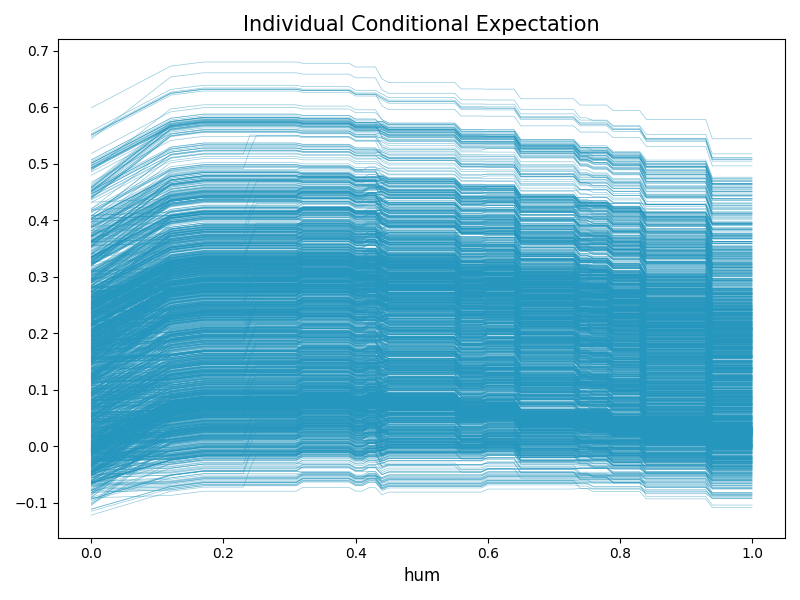

In [9]:
exp.model_explain(model='XGB2', show='ice', uni_feature='hum', original_scale=True)

We can also use sklearn's PDP plot with some changes to the instantiation to get the ICE plot

In [16]:
import polars as pl
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

In [2]:
br = pd.read_csv("./data/bike_rental/day_cleaned.csv")

cols = [
  'season',
  'holiday',
  'workingday',
  'weather_rmp',
  'temp_cel',
  'rel_hum',
  'windspeed_kmh',
  'cnt_2d_bfr',
  'cnt'
]

br = br[cols]
br.head()

,season,holiday,workingday,weather_rmp,temp_cel,rel_hum,windspeed_kmh,cnt_2d_bfr,cnt
0,1,0,1,1,8.050924,43.7273,16.636703,985,1349
1,1,0,1,1,8.200000,59.0435,10.739832,801,1562
2,1,0,1,1,9.305237,43.6957,12.522300,1349,1600
3,1,0,1,1,8.378268,51.8261,6.000868,1562,1606
4,1,0,1,2,8.057402,49.8696,11.304642,1600,1510


In [3]:
# Split the data
y = br['cnt']
X = br.drop('cnt', axis=1)

In [25]:
# Train the model
rfr = RandomForestRegressor()
rfr.fit(X, y)

RandomForestRegressor()

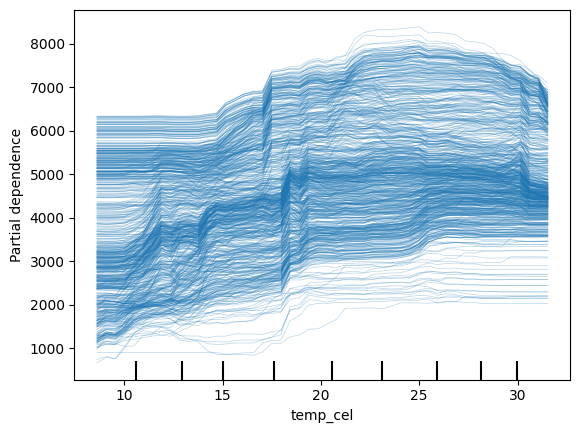

In [29]:
PartialDependenceDisplay.from_estimator(
  rfr,
  X,
  features=['temp_cel'],
  kind='individual',
  grid_resolution=50
)

__Centered ICE Plot__ - All points are centered relative to a fixed value of the feature, and difference in prediction are relative to this point

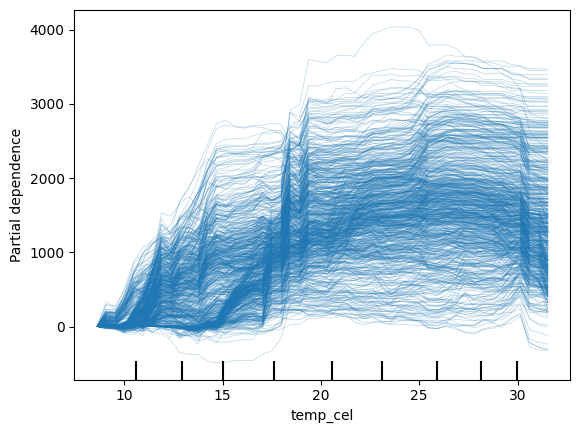

In [ ]:
# Centered ICE Plot
PartialDependenceDisplay.from_estimator(
  rfr,
  X,
  features=['temp_cel'],
  kind='individual',
  centered=True,
  grid_resolution=50
)

---

# LIME

LIME uses a surrogate model (whichi is more interpretable) to explain perturbed data around a selected instance.

The method is local since perturbed data is generated from a single instance. The surrogate model is then trained on the predictions made by the original model with the perturbed data and the explanations are generated.

In [1]:
import polars as pl
import pandas as pd
import numpy as np

In [ ]:
br = pd.read_csv("./data/bike_rental/day_cleaned.csv")

cols = [
  'season',
  'holiday',
  'workingday',
  'weather_rmp',
  'temp_cel',
  'rel_hum',
  'windspeed_kmh',
  'cnt_2d_bfr',
  'cnt'
]

br = br[cols]
br.head()

,season,holiday,workingday,weather_rmp,temp_cel,rel_hum,windspeed_kmh,cnt_2d_bfr,cnt
0,1,0,1,1,8.050924,43.7273,16.636703,985,1349
1,1,0,1,1,8.200000,59.0435,10.739832,801,1562
2,1,0,1,1,9.305237,43.6957,12.522300,1349,1600
3,1,0,1,1,8.378268,51.8261,6.000868,1562,1606
4,1,0,1,2,8.057402,49.8696,11.304642,1600,1510
